CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
!pip install torchsummary


CODE BLOCK: 2

In [3]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? False


CODE BLOCK: 3

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [42]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)

In [43]:
len(test_data)

60000

CODE BLOCK: 5

In [44]:
batch_size = 128 #512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

# New Section

CODE BLOCK: 6

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


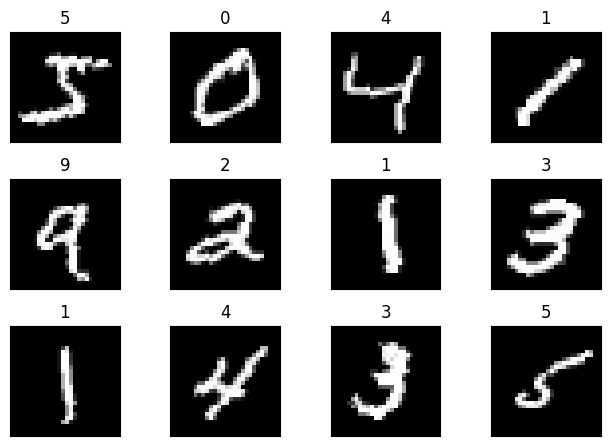

In [45]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv layers with padding=1 to preserve spatial info
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28

        # Fully connected head (flatten after pooling)
        # After 3 MaxPool2d(2): 28->14->7->3
        self.fc1 = nn.Linear(32*3*3, 35)  # flatten 32*3*3 = 288
        self.fc2 = nn.Linear(35, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)   # 28 -> 14

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)   # 14 -> 7

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)   # 7 -> 3

        x = x.view(-1, 32*3*3)   # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [81]:
x = torch.randn(1,1,28,28)  # batch=1
model = Net()
out = model.conv1(x)
print("After conv1:", out.shape)
out = F.max_pool2d(out,2)
print("After pool1:", out.shape)

out = model.conv2(out)
print("After conv2:", out.shape)
out = F.max_pool2d(out,2)
print("After pool2:", out.shape)

out = model.conv3(out)
print("After conv3:", out.shape)
out = F.max_pool2d(out,2)
print("After pool3:", out.shape)


After conv1: torch.Size([1, 16, 28, 28])
After pool1: torch.Size([1, 16, 14, 14])
After conv2: torch.Size([1, 32, 14, 14])
After pool2: torch.Size([1, 32, 7, 7])
After conv3: torch.Size([1, 32, 7, 7])
After pool3: torch.Size([1, 32, 3, 3])


In [82]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 32, 14, 14]           4,640
            Conv2d-3             [-1, 32, 7, 7]           9,248
            Linear-4                   [-1, 35]          10,115
            Linear-5                   [-1, 10]             360
Total params: 24,523
Trainable params: 24,523
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.09
Estimated Total Size (MB): 0.25
----------------------------------------------------------------


In [71]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# model = Net()
model.apply(init_weights)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=288, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=10, bias=True)
)

CODE BLOCK: 8

In [50]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [51]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [87]:
model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
# New Line
criterion = nn.NLLLoss()  # Changed: CrossEntropyLoss → NLLLoss
# criterion = nn.CrossEntropyLoss()
num_epochs = 2

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.3083 Batch_id=468 Accuracy=91.50: 100%|██████████| 469/469 [00:45<00:00, 10.30it/s]


Test set: Average loss: 0.0009, Accuracy: 57784/60000 (96.31%)

Epoch 2


Train: Loss=0.1965 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:46<00:00, 10.00it/s]


Test set: Average loss: 0.0006, Accuracy: 58569/60000 (97.61%)



In [86]:
  def count_parameters(model):
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total:,}")
    return total

# Usage:
# model = Net().to(device)
count_parameters(model)

Total parameters: 24,523


24523

CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

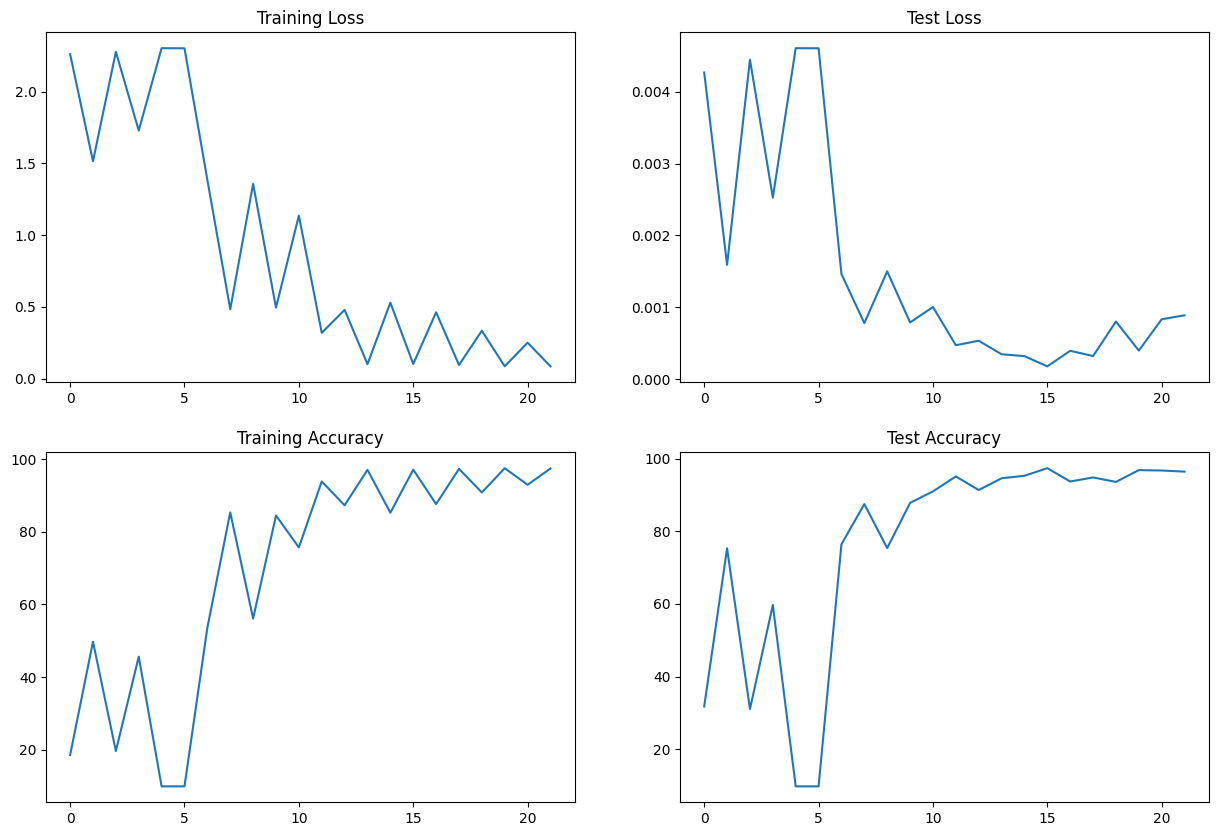

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")